# Causal Modelling with DoWhy and EconML

# Imports

In [57]:
import numpy as np
import pandas as pd

from dowhy import CausalModel, plotter
from IPython.display import Image, display
import matplotlib

# Read data

In [6]:
df = pd.read_csv('../data/causal_df.csv')

In [7]:
df.head()

,Unnamed: 0,date,day_of_week,weather_region_cd,maximum_feels_like_temperature,rainfall,sunshine_td,avg_ice_cream_price,ice_cream_sold,cpih,month
0,0,2022-03-27,0.0,1.0,15.4,0.2,12.1,2.704702,1498.0,6.2,3.0
1,1,2022-03-27,0.0,10.0,12.7,0.0,10.6,2.704702,2285.0,6.2,3.0
2,2,2022-03-27,0.0,11.0,15.1,0.0,10.2,2.704702,5509.0,6.2,3.0
3,3,2022-03-27,0.0,12.0,10.7,0.0,5.3,2.704702,7776.0,6.2,3.0
4,4,2022-03-27,0.0,13.0,13.1,0.0,8.6,2.704702,4903.0,6.2,3.0


# Creating Causal Graph

In [26]:
causal_graph = """
digraph {

weather_region_cd;
maximum_feels_like_temperature;
avg_ice_cream_price;
ice_cream_sold;
U[label="Unobserved Confounders"];

weather_region_cd->maximum_feels_like_temperature;
weather_region_cd->avg_ice_cream_price;

month->maximum_feels_like_temperature;

U->ice_cream_sold;
avg_ice_cream_price->ice_cream_sold; 
maximum_feels_like_temperature->ice_cream_sold;
weather_region_cd->ice_cream_sold;
month->ice_cream_sold;
}
"""

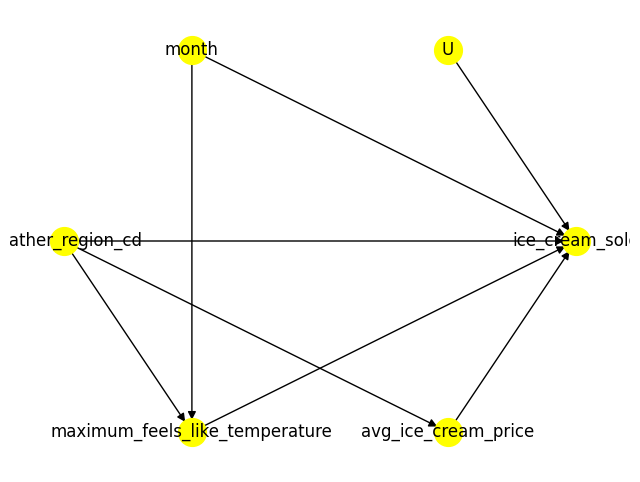

In [27]:
model= CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='maximum_feels_like_temperature',
        outcome='ice_cream_sold'
        )

model.view_model()

# Identify Causal Effects

In [28]:
#Identify the causal effect
estimands = model.identify_effect()
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                           
─────────────────────────────────(E[ice_cream_sold|month,weather_region_cd])
d[maximum_feels_like_temperature]                                           
Estimand assumption 1, Unconfoundedness: If U→{maximum_feels_like_temperature} and U→ice_cream_sold then P(ice_cream_sold|maximum_feels_like_temperature,month,weather_region_cd,U) = P(ice_cream_sold|maximum_feels_like_temperature,month,weather_region_cd)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# Estimate Causal Effects

In [33]:
#Causal Effect Estimation
estimate = model.estimate_effect(estimands,method_name = "backdoor.linear_regression", confidence_intervals=False)
print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                d                                                           
─────────────────────────────────(E[ice_cream_sold|month,weather_region_cd])
d[maximum_feels_like_temperature]                                           
Estimand assumption 1, Unconfoundedness: If U→{maximum_feels_like_temperature} and U→ice_cream_sold then P(ice_cream_sold|maximum_feels_like_temperature,month,weather_region_cd,U) = P(ice_cream_sold|maximum_feels_like_temperature,month,weather_region_cd)

## Realized estimand
b: ice_cream_sold~maximum_feels_like_temperature+month+weather_region_cd+maximum_feels_like_temperature*avg_ice_cream_pri

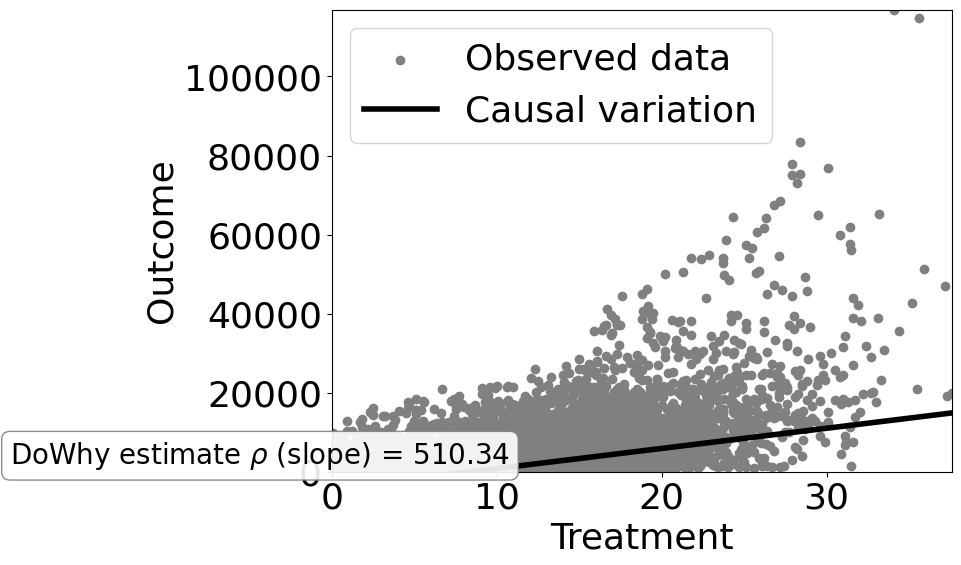

In [60]:
# Plot Slope of line between treamtent and outcome =causal effect
plotter.plot_causal_effect(estimate, df["maximum_feels_like_temperature"], df["ice_cream_sold"])

# Refutes

In [49]:
refutel_random_common_cause = model.refute_estimate(estimands,estimate, "random_common_cause")
refutel_placebo_treatment_refuter = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
refutel_data_subset_refuter = model.refute_estimate(estimands,estimate, "data_subset_refuter")


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: R

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: R

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: R

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: R

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: R

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: R

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: R

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: R

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: R

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/adi.jacobson/miniconda3/envs/icecream/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['avg_ice_cream_price', 'U']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 

In [50]:
print(refutel_random_common_cause)

Refute: Add a random common cause
Estimated effect:510.33811376887184
New effect:510.35920132269973
p value:0.96



In [51]:
print(refutel_placebo_treatment_refuter)

Refute: Use a Placebo Treatment
Estimated effect:510.33811376887184
New effect:0.0
p value:2.0



In [52]:
print(refutel_data_subset_refuter)

Refute: Use a subset of data
Estimated effect:510.33811376887184
New effect:510.0343825588211
p value:1.0



# Final Estimates